In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
from math import pi
import pandas as pd
import math
import tensorflow as tf
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True)


In [4]:
import inspect
def print_t(t, full: bool = True, debug=False):
    if not debug:
        return
    # print(t)
    # return
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name,
             var_val in callers_local_vars if var_val is t]
    if len(names) == 0:
        names.append('')
    if full:
        if hasattr(t, "numpy"):
            print(f"{names[0]}{t.shape}", t.numpy(), sep='\n')
        elif type(t) is np.array:
            print(f"{names[0]}{t.shape}", t, sep='\n')
    else:
        print(f"{names[0]}{t.shape}")


# Simplified

## Equations

\begin{aligned}
\partial_{t} c &= -\nabla \cdot (- \nabla c - c \nabla \Phi) ,\\
\nabla^2 \Phi &= -c .
\end{aligned}

\begin{aligned}
\partial_{x} c(t, 0) &= 0\\
\partial_{x} c(t, 1) &= 0\\
c(0, x) &= 1
\end{aligned}

\begin{aligned}
\Phi(0) &= 1\\
\Phi(1) &= 1\\
\end{aligned}

## Code

In [5]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.net(x)
                c, Fi = r["c"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd
            print_t(j, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               Fi_grd, Fi_lap, \
               j_div

In [6]:
class BoundaryGradientLayer(tf.keras.layers.Layer):
    def __init__(self, net, **kwargs):
        self.net = net
        self.p = kwargs
        super().__init__()

    def call(self, x):
        p = self.p
        sdim = p["sdim"]
        tdim = p["tdim"]
        with tf.GradientTape(persistent=True) as g:
            g.watch(x)
            r = self.net(x)
            c, Fi = r["c"], r["Fi"]
        c_jac = g.batch_jacobian(c, x)[..., 0, :]
        c_grad = c_jac[..., sdim]
        return c, c_grad, Fi

In [7]:
def build_params(dim):
    p = {
        "D": 1.,
        "q": 1.,
        "l": 1,
        "kT": 1.,
        "nu": 1,
        "m": 1.,
        "c_right": 1, "c_start": 1,
        "Fi_left": 1, "Fi_right": 1,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "print_debug": True,
    }
    trim = slice(0, 1+dim)
    p["p_grd"] = tf.constant([0.,1.,0.])[0:dim]
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[trim]
    p["min_dim"] = np.array([0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([1., 1., 1., 1.])[trim]
    p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+dim)
    p["xi"] = p["D"]/p["kT"]
    return p


In [8]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [9]:
def build_pinn(net, p):
    dim = p["dim"]
    ins = [
        tf.keras.layers.Input(shape=(1+dim,)),  # inside
        tf.keras.layers.Input(shape=(1+dim,)),  # left
        tf.keras.layers.Input(shape=(1+dim,)),  # right
        tf.keras.layers.Input(shape=(1+dim,)),  # start
    ]

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    outs = []

    grads = GradientLayer(net, **p)
    c, c_t, c_grd, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 1*l*kT*(z*c))

    l_grad = BoundaryGradientLayer(net, **p)
    c_l, c_grad_l, Fi_l = l_grad(ins[1])
    outs.append(c_grad_l)
    outs.append(Fi_l - p["Fi_left"])

    r_grad = BoundaryGradientLayer(net, **p)
    c_r, c_grad_r, Fi_r = r_grad(ins[2])
    outs.append(c_grad_r)
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[2])
    c_s, Fi_s = r_s["c"], r_s["Fi"]
    outs.append(c_s - p["c_start"])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [10]:
cases = [{}]
cases[0]["p"] = build_params(1)
cases[0]["net"] = build_net([80,40], 'tanh', **cases[0]["p"])
cases[0]["pinn"] = build_pinn(**cases[0])
cases[0]["pinn"].compile('adam', 'mse')

## Sandbox

In [31]:
gl = BoundaryGradientLayer(cases[0]["net"], **cases[0]["p"])
x = tf.constant([[1, 2], [3, 4]], dtype=tf.float32)
gl(x)

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.659],
        [0.465]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.062],
        [ 0.243]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.356],
        [0.101]], dtype=float32)>)

## Tests

In [11]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    x = [x_train, x_train_left, x_train_right, x_train_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)


In [23]:
for i in range(100):
    train(**cases[0])

Epoch 1/10
100/100 - 0s - loss: 0.0327 - tf.__operators__.add_loss: 0.0026 - tf.__operators__.add_1_loss: 0.0017 - boundary_gradient_layer_loss: 7.2328e-04 - tf.math.subtract_loss: 2.2969e-05 - boundary_gradient_layer_1_loss: 0.0046 - tf.math.subtract_1_loss: 3.2371e-05 - tf.math.subtract_2_loss: 0.0230 - 190ms/epoch - 2ms/step
Epoch 2/10
100/100 - 0s - loss: 0.0328 - tf.__operators__.add_loss: 0.0026 - tf.__operators__.add_1_loss: 0.0017 - boundary_gradient_layer_loss: 7.3737e-04 - tf.math.subtract_loss: 1.9841e-05 - boundary_gradient_layer_1_loss: 0.0047 - tf.math.subtract_1_loss: 3.1188e-05 - tf.math.subtract_2_loss: 0.0230 - 143ms/epoch - 1ms/step
Epoch 3/10
100/100 - 0s - loss: 0.0331 - tf.__operators__.add_loss: 0.0029 - tf.__operators__.add_1_loss: 0.0018 - boundary_gradient_layer_loss: 7.4019e-04 - tf.math.subtract_loss: 2.1742e-05 - boundary_gradient_layer_1_loss: 0.0047 - tf.math.subtract_1_loss: 4.6461e-05 - tf.math.subtract_2_loss: 0.0230 - 139ms/epoch - 1ms/step
Epoch 4/10

In [13]:
def test(net, p, num_test_samples = 1, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

In [20]:
cases[0]["res"] = test(**cases[0], num_test_samples=101)

101/101 [==============================] - 0s 580us/step


4/4 [==============================] - 0s 1ms/step


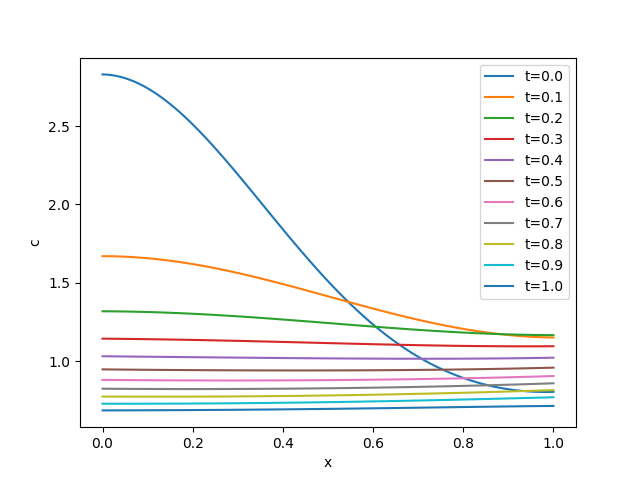

In [24]:
p = cases[0]["p"]
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel("x")
ax.set_ylabel("c")
for i in range(0, 11):
    t = np.full(100, i/10.)
    x = np.linspace(p["min_dim"][1], p["max_dim"][1], 100)
    dims = np.stack([t, x], axis=-1)
    res = cases[0]["net"].predict(dims)["c"]
    ax.plot(dims[:,1], res, label=f't={t[0]}')
    # ax.set_ylim(0, 1)
ax.legend()

In [27]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c)
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()


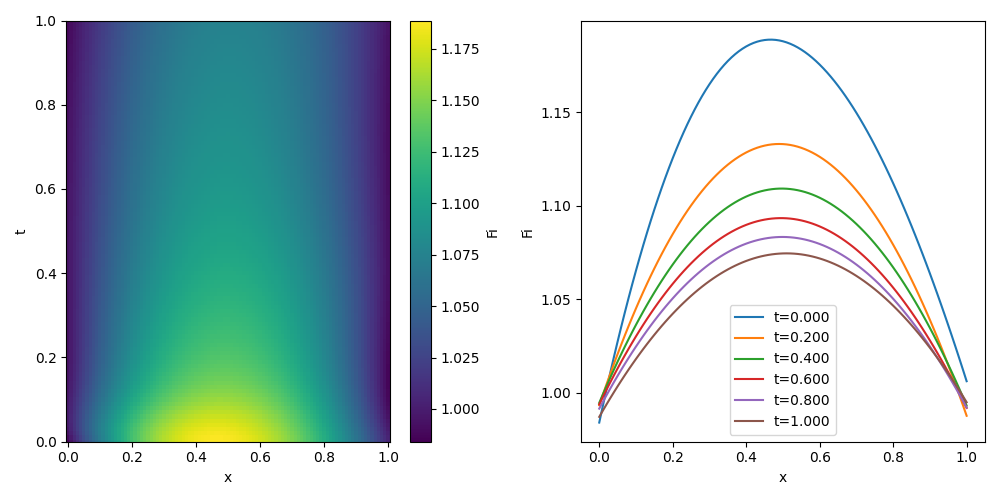

In [28]:
fig = plt.figure(figsize=(10,5))
plot(fig, "Fi", **cases[0])

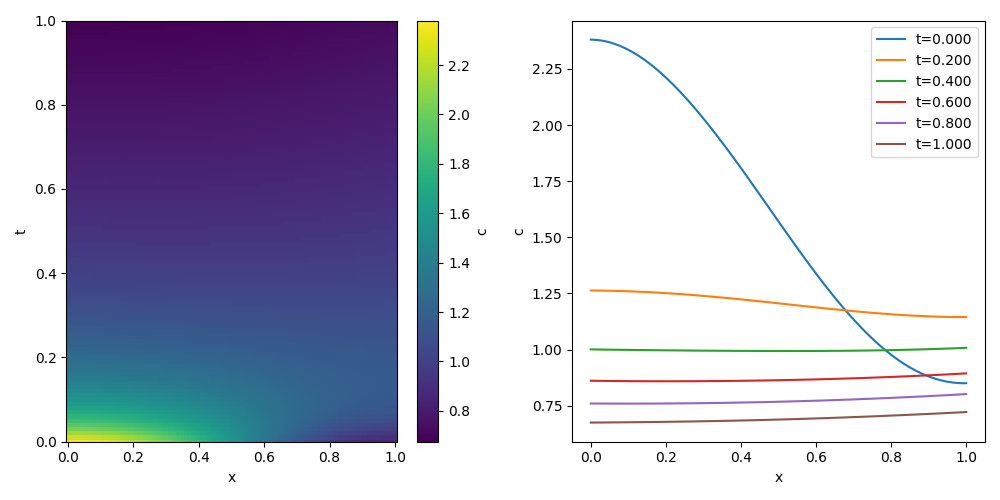

In [29]:
fig = plt.figure(figsize=(10,5))
plot(fig, "c", **cases[0])

# Original

## Equation

## Code

In [ ]:
class GradientLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        self.model = model
        self.p = kwargs
        super().__init__()
        # super().__init__(**kwargs)
        self.D = tf.constant(self.p["D"])
        self.xi = tf.constant(self.p["xi"])
        self.z = tf.constant(self.p["z"])
        self.e = tf.constant(self.p["e"])

    def call(self, x):
        p = self.p
        if "print_debug" in p:
            print_debug = p["print_debug"]
        else:
            print_debug = False
        sdim = p["sdim"]
        tdim = p["tdim"]

        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                r = self.model(x)
                c, v, Fi = r["c"], r["v"], r["Fi"]

            print_t(c, debug=print_debug)
            c_jac = g.batch_jacobian(c, x)[..., 0, :]
            print_t(c_jac, debug=print_debug)
            c_t = c_jac[..., tdim]
            print_t(c_t, debug=print_debug)
            c_grd = c_jac[..., sdim]
            print_t(c_grd, debug=print_debug)

            print_t(v, debug=print_debug)
            v_jac = g.batch_jacobian(v, x)
            print_t(v_jac, debug=print_debug)
            v_t = v_jac[..., tdim][..., 0]
            print_t(v_t, debug=print_debug)
            v_grd = v_jac[..., sdim]
            print_t(v_grd, debug=print_debug)
            v_div = tf.linalg.trace(v_grd)[:, None]
            print_t(v_div, debug=print_debug)
            v_adv = tf.reduce_sum(v[:, None]*v_grd, axis=-1)
            print_t(v_adv, debug=print_debug)

            print_t(Fi, debug=print_debug)
            Fi_jac = g.batch_jacobian(Fi, x)[..., 0, :]
            print_t(Fi_jac, debug=print_debug)
            Fi_grd = Fi_jac[..., sdim]
            print_t(Fi_grd, debug=print_debug)

            j = -p["D"]*c_grd - p["xi"]*p["z"]*p["e"]*c*Fi_grd + c*v
            print_t(j, debug=print_debug)

        v_grd2 = gg.batch_jacobian(v_grd, x)[..., sdim]
        print_t(v_grd2, debug=print_debug)
        v_lap = tf.linalg.trace(v_grd2)
        print_t(v_lap, debug=print_debug)

        Fi_grd_jac = gg.batch_jacobian(Fi_grd, x)
        print_t(Fi_grd_jac, debug=print_debug)
        Fi_lap = tf.linalg.trace(Fi_grd_jac[..., sdim])[:, None]
        print_t(Fi_lap, debug=print_debug)

        j_jac = gg.batch_jacobian(j, x)
        print_t(j_jac, debug=print_debug)
        j_div = tf.linalg.trace(j_jac[..., sdim])[:, None]
        print_t(j_div, debug=print_debug)

        return c, c_t, c_grd, \
               v_t, v_div, v_adv, v_lap, \
               Fi_grd, Fi_lap, \
               j_div


In [ ]:
def build_pinn(net, p):
    ins = []
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # inside
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # left
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # right
    ins.append(tf.keras.layers.Input(shape=(1+p["dim"],)))  # start
    ins.append(tf.keras.layers.Input(1))                    # Fi_start
    grads = GradientLayer(net, **p)

    outs = []

    l, kT, z, p_grd, nu, ro, e = \
        p["l"],p["kT"],p["z"],p["p_grd"],p["nu"],p["ro"], p["e"]

    c, c_t, c_grd, \
        v_t, v_div, v_adv, v_lap, \
        Fi_grd, Fi_lap, j_div = \
        grads(ins[0])
    outs.append(c_t + j_div)
    outs.append(Fi_lap + 4*pi*l*kT*(z*c))
    outs.append(ro*(v_t + v_adv) + p_grd - nu*v_lap + (kT*c_grd + z*e*c*Fi_grd))
    outs.append(v_div)

    r_l = net(ins[1])
    c_l, v_l, Fi_l = r_l["c"], r_l["v"], r_l["Fi"]
    outs.append(c_l - p["c_left"])
    outs.append(v_l - p["v_left"])
    outs.append(Fi_l - p["Fi_left"])

    r_r = net(ins[2])
    c_r, v_r, Fi_r = r_r["c"], r_r["v"], r_r["Fi"]
    outs.append(c_r - p["c_right"])
    outs.append(v_r - p["v_right"])
    outs.append(Fi_r - p["Fi_right"])

    r_s = net(ins[2])
    c_s, v_s, Fi_s = r_s["c"], r_s["v"], r_s["Fi"]
    outs.append(c_s - p["c_start"])
    outs.append(v_s - p["v_start"])
    outs.append(Fi_s - ins[4])

    return tf.keras.models.Model(inputs=ins, outputs=outs)

In [ ]:
# def build_params(dim):
#     p = {
#         "D": 0.006075,
#         "q": 1.,
#         "l": 0.7095,
#         "kT": 1.,
#         "nu": 79.53,
#         "m": 1.,
#         "c_left": 0.01, "c_right": 0.01, "c_start": 0.002,
#         "v_left": 0., "v_right": 0., "v_start": 0,
#         "Fi_left": -0.05, "Fi_right": -0.05, "Fi_start": np.array([[0,-0.05]]),
#         "width": 50.,
#         "dim": dim,
#         "density_water": 26.15,
#         "z": 1.,
#         "e": 1.,
#         "ro": 26.15,
#         "p_grd": tf.constant([0.,1.,0.]),
#     }
#     trim = slice(0, 1+p["dim"])
#     if dim == 1:
#         p["v_const"] = np.array([1.0])
#     else :
#         p["v_const"] = np.array([0., 1., 0.])[0:dim]
#     # p["Fi_start"] = np.loadtxt("Fi.dat")
#     p["p_grd"] = p["p_grd"][0:dim]
#     p["min_dim"] = np.array([ 0., -25., -3., -3.])[trim]
#     p["max_dim"] = np.array([10.,  25.,  3.,  3.])[trim]
#     p["step"] = np.array([1., 0.2,  0.2,  0.2])[trim]
#     p["size"] = p["max_dim"] - p["min_dim"]
#     p["tdim"] = slice(0, 1)
#     p["sdim"] = slice(1, 1+p["dim"])
#     p["xi"] = p["D"]/p["kT"]
#     return p


In [ ]:
def build_params(dim):
    p = {
        "D": 1,
        "q": 1.,
        "l": 1.,
        "kT": 1.,
        "nu": 1.,
        "m": 1.,
        "c_left": 1., "c_right": 1., "c_start": 0.2,
        "v_left": 0., "v_right": 0., "v_start": 0,
        "Fi_left": -1, "Fi_right": -1, "Fi_start": np.array([[0,-0.05]]),
        "width": 50.,
        "dim": dim,
        "density_water": 1.,
        "z": 1.,
        "e": 1.,
        "ro": 1.,
        "p_grd": tf.constant([0.,1.,0.]),
    }
    trim = slice(0, 1+p["dim"])
    if dim == 1:
        p["v_const"] = np.array([1.0])
    else :
        p["v_const"] = np.array([0., 1., 0.])[0:dim]
    # p["Fi_start"] = np.loadtxt("Fi.dat")
    p["p_grd"] = p["p_grd"][0:dim]
    p["min_dim"] = np.array([ 0., 0., 0., 0.])[trim]
    p["max_dim"] = np.array([ 1., 1., 1., 1.])[trim]
    p["step"] = np.array([0.05, 0.05, 0.05, 0.05])[trim]
    p["size"] = p["max_dim"] - p["min_dim"]
    p["tdim"] = slice(0, 1)
    p["sdim"] = slice(1, 1+p["dim"])
    p["xi"] = p["D"]/p["kT"]
    return p


In [ ]:
def build_net(layers, activation, dim, **kwargs):
    inputs = tf.keras.layers.Input(shape=(1+dim,))
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(dim, kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)


In [ ]:
cases = [{},{},{}]

act = 'tanh'
layers = [80, 40]
optimizer = 'adam'
loss = 'mse'
path = f"models/l={layers} act={act} opt={optimizer} loss={loss}"

In [ ]:
best_2dim = tf.keras.models.load_model("2dim model")

In [ ]:
for i in range(3):
    cases[i]["p"] = build_params(1+i)

In [ ]:
for i, case in enumerate(cases):
    cases[i]["net"] = build_net(layers=layers, activation=act, **case["p"])


In [ ]:
for i, case in enumerate(cases):
    cases[i]["pinn"] = build_pinn(case["net"], case["p"])
    cases[i]["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
for i, case in enumerate(cases):
    case["p"] = build_params(1+i)
    case["net"] = build_net(layers=layers, activation=act, **case["p"])
    case["pinn"] = build_pinn(**case)
    case["pinn"].compile(optimizer=optimizer, loss=loss)

In [ ]:
def train(pinn, p, **kwargs):
    n_train_samples = 10000
    n_train_epoch = 10
    
    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    x_train = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.random.rand(n_train_samples, 1+p["dim"]) * size + min_d
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]

    y = [np.zeros((n_train_samples, 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = 100, epochs = n_train_epoch, verbose=2)

for i in range(10):
    train(**cases[1])

In [ ]:
def train_grid(pinn, p, **kwargs):
    n_train_samples = 5
    n_train_epoch = 100

    min_d = p["min_dim"]
    max_d = p["max_dim"]
    size = p["size"]

    dim_range = range(int(1+p["dim"]))

    coords = [np.arange(p["min_dim"][i], p["max_dim"][i], p["step"][i]) for i in dim_range]
    m_coords = np.meshgrid(*coords, indexing='ij')
    x_train = np.stack([m_coord.flatten() for m_coord in m_coords], axis=-1)
    
    x_train_left = np.copy(x_train)
    x_train_left[:, 1] = min_d[1]
    x_train_right = np.copy(x_train)
    x_train_right[:, 1] = max_d[1]
    x_train_start = np.copy(x_train)
    x_train_start[:, 0] = min_d[0]
    Fi_start = np.interp(x_train_start[:, 1], p["Fi_start"][:, 0], p["Fi_start"][:, 1])
    x = [x_train, x_train_left, x_train_right, x_train_start, Fi_start]
    y = [np.zeros((x[0].shape[0], 1))] * len(pinn.output)

    return pinn.fit(x=x, y=y, batch_size = None, epochs = n_train_epoch)

h = train_grid(**cases[1])

In [ ]:
def test(net, p, num_test_samples = 30, **kwargs):
    dims = np.linspace(p["min_dim"], p["max_dim"], num_test_samples).T
    dims = np.split(dims.flatten(), p["dim"]+1)
    mdims = np.meshgrid(*dims, indexing='ij')
    txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)
    return dims, mdims, net.predict(txyz, batch_size=num_test_samples)

cases[1]["res"] = test(**cases[1])

In [ ]:
def plot(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("t")
    im = axc.pcolormesh(dims[0], dims[1], c)
    axc.set_ylim(0., 1.)
    fig.colorbar(im, label=d)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 10
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()


In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "Fi", **cases[0])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot(fig, "c", **cases[0])

In [ ]:
def plot2d(fig, d, res, p, **kwargs):
    dims, mdims, data = res
    c = data[d]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot(121)

    axc.set_xlabel("x")
    axc.set_ylabel("y")
    im = axc.pcolormesh(dims[1], dims[2], c[0].T)
    fig.colorbar(im).ax.set_ylabel(d, labelpad=0)

    axc = fig.add_subplot(122)
    axc.set_xlabel("x")
    axc.set_ylabel(d)
    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    count = 5
    for i in range(count):
        j = int(i * dims[0].shape[0] / count)
        axc.plot(dims[1], c[(j, slice(None),) + other_dim], label=f't={dims[0][j]:.3f}')
    axc.plot(dims[1], c[(-1, slice(None),) + other_dim], label=f't={dims[0][-1]:.3f}')
    axc.legend(loc='best')
    fig.tight_layout()

In [ ]:
Fi = np.reshape(cases[1]["res"][2]["Fi"], cases[1]["res"][1][1].shape)
Fi[-1, 0, 15]

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "Fi", **cases[1])

In [ ]:
fig = plt.figure(figsize=(10,4))
plot2d(fig, "c", **cases[1])

In [ ]:
def plot_c(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][2:] / 2)
    for t in range(0, 30, 5):
        axc.plot(dims[1], c[(t, slice(None),) + other_dim], label=f't={dims[0][t]:.3f}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[(last_idx, slice(None),) + other_dim], label=f't={dims[0][last_idx]:.3f}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)


In [ ]:
cases[2]["net"].save("3dim model relu 30000000")

In [ ]:
fig = plt.figure()
res = test(best_2dim, cases[2]["p"])
plot_c(fig, 2, res, cases[2]["p"])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
fig = plt.figure()
plot_c(fig, 2, **cases[2])

In [ ]:
def plot_c_y(fig: plt.Figure, i, res, p, **kwargs):
    dims, mdims, data = res
    c = data["c"]
    c = c.reshape(mdims[0].shape)
    axc = fig.add_subplot()

    analit = np.loadtxt("eof_analytical.dat")
    axc.plot(analit[:, 0], analit[:, 1], 'o', mfc="none", label='analit')
    axc.set_title(f'Размерность: {p["dim"]}')
    axc.set_xlabel("x")
    axc.set_ylabel("c")

    other_dim = tuple(int(s) for s in p["size"][1:] / 2)
    for t in range(0, 50, 10):
        axc.plot(dims[1], c[t,other_dim[0], :], label=f't={t}')
    last_idx = dims[1].shape[0] - 1
    axc.plot(dims[1], c[t, other_dim[0], :], label=f't={last_idx}')
    axc.legend(loc='best')
    # axc.set_ylim(top=0.01)

fig = plt.figure()
plot_c_y(fig, 2, **cases[1])

In [ ]:
def save(net):
    p = path + f"/{net.layers[0].output_shape[-1][-1]-1}"
    pathlib.Path(p).mkdir(parents=True, exist_ok=True)
    net.save(p)

In [ ]:
networks = [
    tf.keras.models.load_model(path+'/1'),
    tf.keras.models.load_model(path+'/2'),
    tf.keras.models.load_model(path+'/3'),
]

In [ ]:
def build_net(layers, activation, **kwargs):

    # input layer
    inputs = tf.keras.layers.Input(shape=(1+kwargs["dim"],))
    # hidden layers
    x = inputs
    for layer in layers:
        x = tf.keras.layers.Dense(layer, activation=activation,
                                    kernel_initializer='he_normal')(x)

    outs = {
        "c": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x),
        "v": tf.keras.layers.Dense(kwargs["dim"], kernel_initializer='he_normal')(x),
        "Fi": tf.keras.layers.Dense(1, kernel_initializer='he_normal')(x)
    }
    return tf.keras.models.Model(inputs=inputs, outputs=outs)
